In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.api.types import CategoricalDtype 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from xgboost import plot_tree, plot_importance

In [2]:
df = pd.read_csv('dataset_processed.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
df2 = df.copy()
print(df2.shape)

# Lists
companies = np.unique(df2.company)
dates = np.unique(df2.date)
days = np.unique(df2.day)
cards = np.unique(df2.cardtype)
schemes = np.unique(df2.scheme)
journals = list(np.unique(df2.journalcat)) + ['All']

# List of fields available to filter on
fieldtypes = [elem for elem in df2.columns if elem not in ['pspreference', 'bin', 'company', 'amount_usd', 'date_time', 'date']]
fieldtypes = sorted(fieldtypes)

(224167, 25)


# Functions for Report

In [4]:
def preprocessing_df(df2, company_dd):
    print(f'****Preparing data for Company = {company_dd}****')
    if company_dd == 'All':
        df3 = df2.copy()
    else:
        # Filter by company
        df3 = df2[df2['company'] == company_dd]
        
    # Outlier detection
    print('Before dropping outlier: ', df3.shape)
    df3 = df3[(np.abs(stats.zscore(df3['amount_usd'])) < 3)]
    print('After dropping outlier: ', df3.shape)

    # Drop irrelevant columns for ML
    df3 = df3.drop(['pspreference', 'company', 'bin', 'date_time', 'date', 
                   'is_approved', 'genericresponse', 'threedattempt', 'journalcat', 
                   'journaltype', 'acquirer', 'acquireraccount'], axis=1)
    print('Data shape: ', df3.shape)
    return df3

# # Test
# company_dd = 'All' #companies[0]
# df3 = preprocessing_df(df2, company_dd)

In [5]:
# Fraud modelling
def model_preprocessing(df3):
    # Train test split
    X = df3.drop('is_fraud', axis=1)
    y = df3['is_fraud']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Scale amount_usd col 
    ss = StandardScaler()
    X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
    X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])

    # Drop original amount_usd col, keep scaled col
    X_train = X_train.drop(['amount_usd'], axis =1)
    X_test = X_test.drop(['amount_usd'], axis =1)
    
    # One Hot Encoding with training set only
    OHE_df = pd.DataFrame()
    categorical_cols = ['currencycode', 'issuercountrygroup', 'scheme', 'merchant', 'is_domestic',
                        'day', 'weektype', 'timeofday', 'cardtype', 'debit_credit', 'amount_bin']

    for i in categorical_cols:
        OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
        OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)


    OHE_df = OHE_df.drop(categorical_cols, axis= 1) # remove original categorical columns, keep OHE columns only
    X_no_cat = X.drop(categorical_cols, axis= 1) # Get numerical column
    OHE_df = pd.concat([X_no_cat, OHE_df],axis=1) # concat numeric and OHE columns into OHE_df

    # Resplit X dataset with OHE columns
    OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

    print('Before OHE, n features = ', X_train.shape[1])
    print('After OHE, n features = ', OHE_train.shape[1])
    return OHE_train, OHE_test, y_train, y_test 

# # Test
# OHE_train, OHE_test, y_train, y_test= model_preprocessing(df3)

In [6]:
def feature_imp_model(df3, model):
    OHE_train, OHE_test, y_train, y_test= model_preprocessing(df3)
    
    if model == 'logreg':
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        model.fit(OHE_train, y_train)
        
        # Obtain importances from coefficients
        importances = pd.DataFrame(data={
            'Attribute': OHE_train.columns,
            'Importance': model.coef_[0]
        })
        
        # Get top 10 positive and top 10 negative coeff
        importances = importances.sort_values(by='Importance', ascending=False)
        top_features = pd.concat([importances[:10], importances[-10:]]).reset_index(drop=True)
        
    else:
        model = XGBClassifier()
        model.fit(OHE_train, y_train)
        
        # Obtain importances from coefficients
        importances = pd.DataFrame(data={
            'Attribute': OHE_train.columns,
            'Importance': model.feature_importances_
        })
        
        # Get top 10 positive and top 10 negative coeff
        top_features = importances.sort_values(by='Importance', ascending=False)[:10]
    

    # Plot top features
    plt.bar(x=top_features['Attribute'], height=top_features['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.show()
    
    # Accuracy score
    y_pred = model.predict(OHE_test)
    test_score = accuracy_score(y_test,y_pred)

    scores = cross_val_score(model, OHE_train, y_train, cv=10)
    print('Cross-Validation Accuracy Scores', scores)

    print('/nTest score: ', test_score)
    print('Mean CV score: ', np.mean(scores))
    return(scores)

# # Test
# for m in ['logreg', 'xgb']:
#     print(f'*****Model = {m}*****')
#     tempname = m + '_scores'
#     model = m
#     tempname = feature_imp_model(df3, model)

# Run report

## All companies

****Preparing data for Company = All****
Before dropping outlier:  (224167, 25)
After dropping outlier:  (214169, 25)
Data shape:  (214169, 13)
*****Model = logreg*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  55


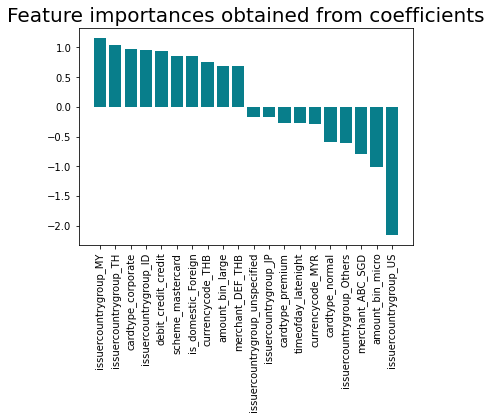

Cross-Validation Accuracy Scores [0.91940002 0.92004202 0.92004202 0.91963348 0.91916657 0.91968715
 0.92067939 0.92062102 0.91951205 0.91951205]
/nTest score:  0.9222813652705795
Mean CV score:  0.9198295786837478
*****Model = xgb*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  55


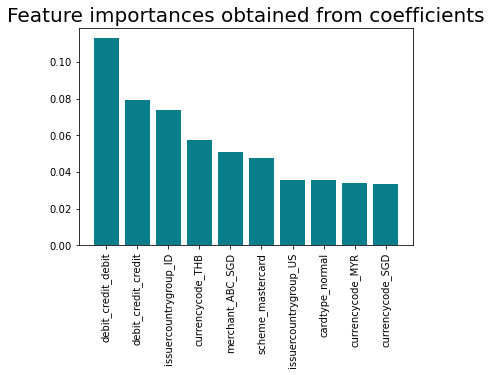

Cross-Validation Accuracy Scores [0.9370258  0.93737598 0.93305708 0.93690907 0.93685071 0.93626335
 0.93591315 0.93754742 0.93813109 0.93754742]
/nTest score:  0.9369192697389924
Mean CV score:  0.9366621069361487


In [7]:
# Test 
company_dd = 'All' #companies[0]
df3 = preprocessing_df(df2, company_dd)

for m in ['logreg', 'xgb']:
    print(f'*****Model = {m}*****')
    tempname = m + '_scores'
    model = m
    tempname = feature_imp_model(df3, model)

## ABC

****Preparing data for Company = ABCLimited****
Before dropping outlier:  (99420, 25)
After dropping outlier:  (95079, 25)
Data shape:  (95079, 13)
*****Model = logreg*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  46


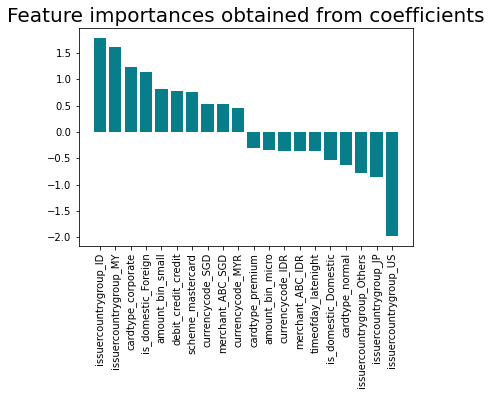

Cross-Validation Accuracy Scores [0.89851453 0.8998291  0.89838307 0.89836971 0.89731791 0.89810676
 0.89863266 0.90047331 0.89929003 0.89836971]
/nTest score:  0.8945624737063526
Mean CV score:  0.8987286783237038
*****Model = xgb*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  46


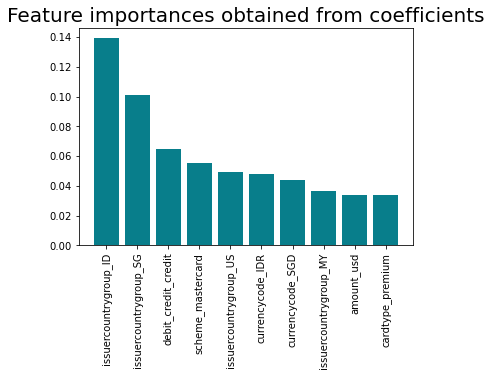

Cross-Validation Accuracy Scores [0.91534113 0.91336927 0.91218614 0.91099132 0.91493558 0.91533
 0.9105969  0.91572443 0.90928215 0.9137523 ]
/nTest score:  0.9136516617585192
Mean CV score:  0.9131509216862653


In [8]:
# Test 
company_dd = companies[0]
df3 = preprocessing_df(df2, company_dd)

for m in ['logreg', 'xgb']:
    print(f'*****Model = {m}*****')
    tempname = m + '_scores'
    model = m
    tempname = feature_imp_model(df3, model)

## DEF

****Preparing data for Company = DEFLimited****
Before dropping outlier:  (52567, 25)
After dropping outlier:  (49768, 25)
Data shape:  (49768, 13)
*****Model = logreg*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  47


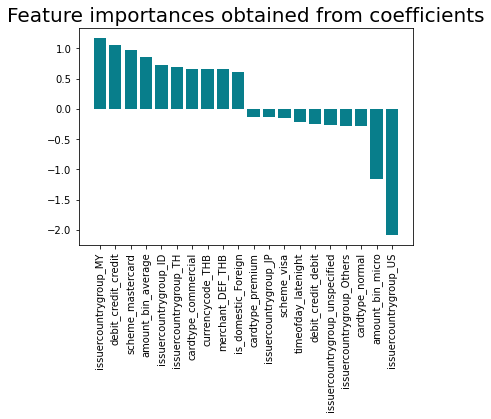

Cross-Validation Accuracy Scores [0.93520844 0.93696635 0.93420392 0.93696635 0.93845767 0.93594574
 0.93594574 0.93669932 0.93720171 0.93644813]
/nTest score:  0.9368093228852723
Mean CV score:  0.9364043369743096
*****Model = xgb*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  47


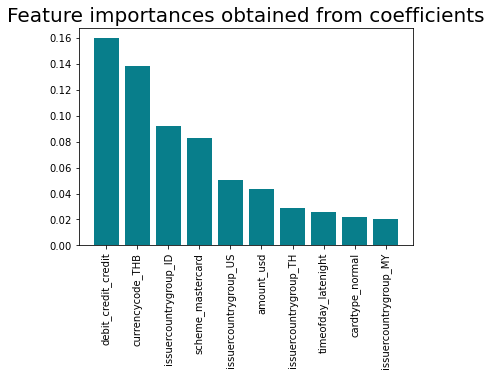

Cross-Validation Accuracy Scores [0.94977398 0.95554997 0.95228528 0.95429432 0.95126853 0.94624466
 0.95126853 0.95252449 0.95704597 0.94775182]
/nTest score:  0.9520795660036167
Mean CV score:  0.9518007560018577


In [9]:
# Test 
company_dd = companies[1]
df3 = preprocessing_df(df2, company_dd)

for m in ['logreg', 'xgb']:
    print(f'*****Model = {m}*****')
    tempname = m + '_scores'
    model = m
    tempname = feature_imp_model(df3, model)

## XYZ

****Preparing data for Company = XYZLimited****
Before dropping outlier:  (72180, 25)
After dropping outlier:  (69241, 25)
Data shape:  (69241, 13)
*****Model = logreg*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  49


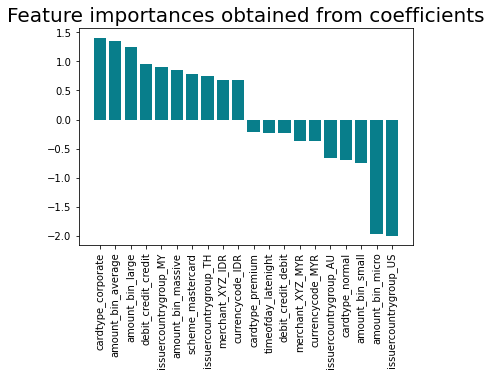

Cross-Validation Accuracy Scores [0.93916968 0.93898917 0.93951977 0.93970031 0.93861708 0.94042246
 0.938256   0.94042246 0.93897815 0.94024192]
/nTest score:  0.9403567044551954
Mean CV score:  0.9394316996056189
*****Model = xgb*****


<ipython-input-5-c612588069df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
<ipython-input-5-c612588069df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])


Before OHE, n features =  12
After OHE, n features =  49


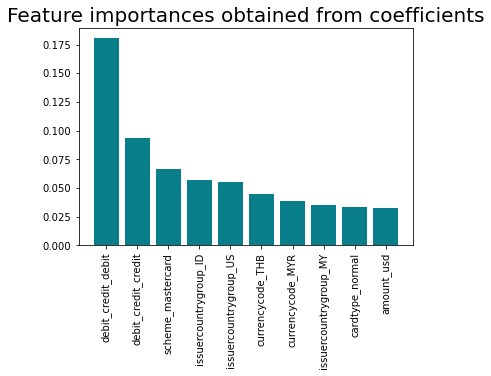

Cross-Validation Accuracy Scores [0.95379061 0.95613718 0.95540711 0.95594873 0.95450442 0.95378227
 0.95649034 0.95287958 0.95829572 0.95667088]
/nTest score:  0.9587695862517149
Mean CV score:  0.9553906855425558


In [10]:
# Test 
company_dd = companies[2]
df3 = preprocessing_df(df2, company_dd)

for m in ['logreg', 'xgb']:
    print(f'*****Model = {m}*****')
    tempname = m + '_scores'
    model = m
    tempname = feature_imp_model(df3, model)

# Raw code

### Preparing dataset for Modelling

In [11]:
# # Train test split
# X = df3.drop('is_fraud', axis=1)
# y = df3['is_fraud']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # Scale amount_usd col 
# ss = StandardScaler()
# X_train['amount_scaled'] = ss.fit_transform(X_train[['amount_usd']])
# X_test['amount_scaled'] = ss.transform(X_test[['amount_usd']])

# # Drop original amount_usd col, keep scaled col
# X_train = X_train.drop(['amount_usd'], axis =1)
# X_test = X_test.drop(['amount_usd'], axis =1)

# # One Hot Encoding with training set only
# OHE_df = pd.DataFrame()
# categorical_cols = ['currencycode', 'issuercountrygroup', 'scheme', 'merchant', 'is_domestic',
#                     'day', 'weektype', 'timeofday', 'cardtype', 'debit_credit', 'amount_bin']

# for i in categorical_cols:
#     OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
#     OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)
    
    
# OHE_df = OHE_df.drop(categorical_cols, axis= 1) # remove original categorical columns, keep OHE columns only
# X_no_cat = X.drop(categorical_cols, axis= 1) # Get numerical column
# OHE_df = pd.concat([X_no_cat, OHE_df],axis=1) # concat numeric and OHE columns into OHE_df

# # Resplit X dataset with OHE columns
# OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

# print('Before OHE, n features = ', X_train.shape[1])
# print('After OHE, n features = ', OHE_train.shape[1])

### Logistic Regression

In [12]:
# # Obtain importances from coefficients
# model = LogisticRegression(solver='lbfgs', max_iter=1000)
# model.fit(OHE_train, y_train)

# importances = pd.DataFrame(data={
#     'Attribute': OHE_train.columns,
#     'Importance': model.coef_[0]
# })
# importances = importances.sort_values(by='Importance', ascending=False)

# # Get top 10 positive and top 10 negative coeff
# top_features = pd.concat([importances[:10], importances[-10:]]).reset_index(drop=True)

# # Plot top features
# plt.bar(x=top_features['Attribute'], height=top_features['Importance'], color='#087E8B')
# plt.title('Feature importances obtained from coefficients', size=20)
# plt.xticks(rotation='vertical')
# plt.show()

# # Accuracy score
# y_pred = model.predict(OHE_test)
# test_score = accuracy_score(y_test,y_pred)

# scores = cross_val_score(model, OHE_train, y_train, cv=10)
# print('Cross-Validation Accuracy Scores', scores)

# print('/nTest score: ', test_score)
# print('Mean CV score: ', np.mean(scores))

# # CV accuracy = 89%

### Decision Tree

In [13]:
# model = XGBClassifier()
# model.fit(OHE_train, y_train)
# importances = pd.DataFrame(data={
#     'Attribute': OHE_train.columns,
#     'Importance': model.feature_importances_
# })
# importances = importances.sort_values(by='Importance', ascending=False)

# # Plot top 10 features
# plt.bar(x=importances[:10]['Attribute'], height=importances[:10]['Importance'], color='#087E8B')
# plt.title('Feature importances obtained from coefficients', size=20)
# plt.xticks(rotation='vertical')
# plt.show()

# # Accuracy score
# y_pred = model.predict(OHE_test)
# test_score = accuracy_score(y_test,y_pred)

# scores = cross_val_score(model, OHE_train, y_train, cv=10)
# print('Cross-Validation Accuracy Scores', scores)

# print('Test score: ', test_score)
# print('Mean CV score: ', np.mean(scores))

# # CV accuracy = 91%

In [14]:
# plot_tree(model)
# fig = plt.gcf()
# fig.set_size_inches(150, 100)
# fig.savefig('xgbtree.png')